In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Path
source_image_folder = '/content/drive/MyDrive/Dataset ComVis/test'
csv_path = '/content/drive/MyDrive/Dataset ComVis/dataset.csv'
output_base_dir = '/content/drive/MyDrive/Dataset ComVis/dataset'

# Load CSV
df = pd.read_csv(csv_path)

# Filter file yang eksis
df['full_path'] = df['path'].apply(lambda x: os.path.join(source_image_folder, x))
df = df[df['full_path'].apply(os.path.exists)]

# Split train/val/test
train_val, test = train_test_split(df, test_size=0.2, stratify=df['level'], random_state=42)
train, val = train_test_split(train_val, test_size=0.25, stratify=train_val['level'], random_state=42)  # 0.25 x 0.8 = 0.2

splits = {
    'train': train,
    'val': val,
    'test': test
}

# Copy files ke struktur /train/label/, /val/label/, /test/label/
for split_name, split_df in splits.items():
    print(f"📁 Memproses: {split_name} ({len(split_df)} file)")
    for _, row in tqdm(split_df.iterrows(), total=len(split_df)):
        label = str(row['level'])
        filename = row['path']
        src = os.path.join(source_image_folder, filename)
        dst_dir = os.path.join(output_base_dir, split_name, label)
        os.makedirs(dst_dir, exist_ok=True)
        dst = os.path.join(dst_dir, filename)
        shutil.copy(src, dst)

print("✅ Dataset berhasil dipisah ke train/val/test per label.")


📁 Memproses: train (978 file)


100%|██████████| 978/978 [08:14<00:00,  1.98it/s]


📁 Memproses: val (327 file)


100%|██████████| 327/327 [02:28<00:00,  2.20it/s]


📁 Memproses: test (327 file)


100%|██████████| 327/327 [02:35<00:00,  2.10it/s]

✅ Dataset berhasil dipisah ke train/val/test per label.


In [ ]:
# Sebelum menjalankan kode preprocessing/pelatihan
# Buat folder sementara di runtime lokal Colab
!mkdir -p /content/temp_dataset/train
!mkdir -p /content/temp_dataset/val

# Salin data dari Google Drive ke runtime lokal
# Ini akan memakan waktu, tapi hanya sekali
print("Mulai menyalin train data ke runtime lokal...")
!cp -r /content/drive/MyDrive/Dataset\ ComVis/dataset/train/* /content/temp_dataset/train/
print("Selesai menyalin train data.")
print("Mulai menyalin val data ke runtime lokal...")
!cp -r /content/drive/MyDrive/Dataset\ ComVis/dataset/val/* /content/temp_dataset/val/
print("Selesai menyalin val data.")

# Ubah path train_dir dan val_dir
train_dir = '/content/temp_dataset/train'
val_dir = '/content/temp_dataset/val'

Mulai menyalin train data ke runtime lokal...
Selesai menyalin train data.
Mulai menyalin val data ke runtime lokal...
Selesai menyalin val data.


### **PyTorch**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from copy import deepcopy
import time
import os

In [ ]:
image_size = 224
batch_size = 64
initial_lr = 1e-4
fine_tune_lr = 1e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs_1 = 20
num_epochs_2 = 20

In [ ]:
# --- Data Transformation (dengan Normalisasi ImageNet yang disarankan) ---
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), # Tambahan: Sangat relevan untuk citra medis
    transforms.RandomRotation(degrees=15), # Tambahan: Augmentasi rotasi
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
base_dir = '/content/drive/MyDrive/Dataset ComVis/dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test) # Akan mengambil jumlah kelas dari folder
num_classes = len(train_dataset.classes)
print(f"Jumlah kelas terdeteksi      : {num_classes} -> {train_dataset.classes}")
print(f"Ukuran dataset training      : {len(train_dataset)} gambar")
print(f"Ukuran dataset validation    : {len(val_dataset)} gambar")
print(f"Ukuran dataset testing       : {len(test_dataset)} gambar")

Jumlah kelas terdeteksi      : 6 -> ['0', '1', '2', '3', '4', '5']
Ukuran dataset training      : 978 gambar
Ukuran dataset validation    : 327 gambar
Ukuran dataset testing       : 327 gambar


In [ ]:
# --- PENTING: Penyesuaian DataLoader untuk CPU Bottleneck ---
# Coba tingkatkan num_workers
# num_workers > 0 akan menjalankan loading data di subprocess terpisah (menggunakan inti CPU lain)
# Coba nilai 2, 4, atau bahkan os.cpu_count() - 1
# Perhatikan bahwa terlalu banyak num_workers bisa menghabiskan RAM sistem.
num_cpu_cores = os.cpu_count()
print(f"Jumlah core CPU yang terdeteksi: {num_cpu_cores}")
optimal_workers = min(num_cpu_cores, 12)
print(f"DataLoader menggunakan {optimal_workers} worker.") # Coba 4 worker sebagai awal yang baik
# Hindari num_workers = 0 jika memungkinkan, kecuali untuk debugging
# Jika Anda masih melihat CPU bottleneck, naikkan num_workers lebih tinggi.
# Jika Anda mulai kehabisan RAM sistem, turunkan num_workers.

Jumlah core CPU yang terdeteksi: 8
DataLoader menggunakan 8 worker.


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=optimal_workers, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=optimal_workers, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=optimal_workers, pin_memory=True)

In [ ]:
# ✅ Load pretrained ResNet18-152 (tanpa classifier akhir)
resnets = {
    "resnet18": (models.resnet18(weights=None), 512),
    "resnet34": (models.resnet34(weights=None), 512),
    "resnet50": (models.resnet50(weights=None), 2048),
    "resnet101": (models.resnet101(weights=None), 2048),
    "resnet152": (models.resnet152(weights=None), 2048)
}

frozen_model_paths = {
    "resnet18": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet18_frozen.pth",
    "resnet34": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet34_frozen.pth",
    "resnet50": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet50_frozen.pth",
    "resnet101": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet101_frozen.pth",
    "resnet152": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet152_frozen.pth",
}

In [ ]:
# Dictionary untuk menyimpan model dan optimizer
models_dict = {}
optimizers = {}

In [ ]:
# Siapkan model: freeze backbone + custom classifier
for name, (model, feat_dim) in resnets.items():
    # Freeze semua layer backbone
    for param in model.parameters():
        param.requires_grad = False

    # Ganti classifier (fc layer)
    model.fc = nn.Sequential(
        nn.Linear(feat_dim, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)  # num_classes sudah kamu definisikan sebelumnya
    )

    # Pindahkan ke device (GPU/CPU)
    model = model.to(device)

    # Optimizer hanya untuk classifier
    optimizer = optim.Adam(model.fc.parameters(), lr=initial_lr)

    # Simpan ke dict
    models_dict[name] = model
    optimizers[name] = optimizer

# Loss function
criterion = nn.CrossEntropyLoss()
print("✅ Semua model siap digunakan: ", list(models_dict.keys()))

✅ Semua model siap digunakan:  ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']


In [ ]:
import time
import torch

def train_one_phase(model, optimizer, num_epochs, train_loader, val_loader, phase_name="", save_path=None):
    print(f"\n🔧 Phase: {phase_name}")
    best_val_acc = 0.0
    patience = 7
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_loss = val_loss_total / len(val_loader)
        val_acc = 100. * val_correct / val_total

        duration = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} ({duration:.2f}s) - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"  ✅ Model terbaik disimpan ke {save_path} dengan Val Acc: {best_val_acc:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  ⏹️ Early stopping setelah {patience} epoch tanpa peningkatan.")
                break


In [ ]:
# Jalankan pelatihan untuk semua model
for name in models_dict:
    model = models_dict[name]
    optimizer = optimizers[name]

    print(f"\n=========================== {name.upper()} ===========================")

    # Phase 1: Latih hanya classifier (frozen backbone)
    print(f"🔧 Phase 1: Training classifier only (frozen backbone)")
    train_one_phase(
        model, optimizer, num_epochs_1,
        train_loader, val_loader,
        phase_name=f"{name}_frozen",
        save_path=f"best_model_{name}_frozen.pth"
    )

    # Phase 2: Fine-tuning semua layer
    print(f"\n🔧 Phase 2: Fine-tuning full model (unfreeze all layers)")
    for param in model.parameters():
        param.requires_grad = True

    # Ganti optimizer untuk seluruh parameter
    optimizer = optim.Adam(model.parameters(), lr=fine_tune_lr)

    train_one_phase(
        model, optimizer, num_epochs_2,
        train_loader, val_loader,
        phase_name=f"{name}_fine_tune",
        save_path=f"best_model_{name}_fine_tune.pth"
    )



=========================== RESNET18 ===========================
🔧 Phase 1: Training classifier only (frozen backbone)

🔧 Phase: resnet18_frozen
Epoch 1/20 (19.29s) - Train Loss: 1.7016, Train Acc: 28.63% | Val Loss: 1.5900, Val Acc: 36.70%
  ✅ Model terbaik disimpan ke best_model_resnet18_frozen.pth dengan Val Acc: 36.70%
Epoch 2/20 (17.06s) - Train Loss: 1.5318, Train Acc: 44.58% | Val Loss: 1.4576, Val Acc: 51.99%
  ✅ Model terbaik disimpan ke best_model_resnet18_frozen.pth dengan Val Acc: 51.99%
Epoch 3/20 (17.40s) - Train Loss: 1.4535, Train Acc: 50.92% | Val Loss: 1.3711, Val Acc: 55.96%
  ✅ Model terbaik disimpan ke best_model_resnet18_frozen.pth dengan Val Acc: 55.96%
Epoch 4/20 (17.11s) - Train Loss: 1.3805, Train Acc: 54.60% | Val Loss: 1.2930, Val Acc: 54.43%
Epoch 5/20 (17.05s) - Train Loss: 1.3204, Train Acc: 56.54% | Val Loss: 1.2229, Val Acc: 58.10%
  ✅ Model terbaik disimpan ke best_model_resnet18_frozen.pth dengan Val Acc: 58.10%
Epoch 6/20 (16.59s) - Train Loss: 1.25

In [ ]:
for arch, (model, feat_dim) in resnets.items():
    print(f"🔧 Fine-tuning model: {arch}")

    # Ganti classifier
    model.fc = nn.Sequential(
        nn.Linear(feat_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 6)
    )

    # Load model frozen dari drive
    model.load_state_dict(torch.load(frozen_model_paths[arch], map_location=device))
    model = model.to(device)

    # Unfreeze semua layer
    for param in model.parameters():
        param.requires_grad = True

    # Buat optimizer baru untuk semua layer
    optimizer = torch.optim.Adam(model.parameters(), lr=fine_tune_lr)

    # Jalankan training fase 2 (fine-tuning)
    save_path = f"/content/drive/MyDrive/Model_ResNet_Comvis/best_model_{arch}_fine_tune.pth"
    train_one_phase(model, optimizer, num_epochs_2, train_loader, val_loader,
                    phase_name="fine_tune", save_path=save_path)

🔧 Fine-tuning model: resnet18

🔧 Phase: fine_tune
Epoch 1/20 (110.20s) - Train Loss: 0.4674, Train Acc: 84.46% | Val Loss: 0.5961, Val Acc: 75.84%
  ✅ Model terbaik disimpan ke /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet18_fine_tune.pth dengan Val Acc: 75.84%
Epoch 2/20 (24.38s) - Train Loss: 0.4503, Train Acc: 85.07% | Val Loss: 0.5945, Val Acc: 74.92%
Epoch 3/20 (22.90s) - Train Loss: 0.4213, Train Acc: 86.61% | Val Loss: 0.6000, Val Acc: 75.54%
Epoch 4/20 (22.81s) - Train Loss: 0.4331, Train Acc: 85.69% | Val Loss: 0.5866, Val Acc: 75.84%
Epoch 5/20 (22.06s) - Train Loss: 0.4114, Train Acc: 85.99% | Val Loss: 0.5797, Val Acc: 75.84%
Epoch 6/20 (22.71s) - Train Loss: 0.3935, Train Acc: 86.09% | Val Loss: 0.5835, Val Acc: 76.45%
  ✅ Model terbaik disimpan ke /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet18_fine_tune.pth dengan Val Acc: 76.45%
Epoch 7/20 (24.03s) - Train Loss: 0.3794, Train Acc: 87.73% | Val Loss: 0.5799, Val Acc: 76.45%
Epoch 8/20 (22.82

In [ ]:
# 🔁 Simpan ulang semua model fine-tuned ke Google Drive
save_dir = "/content/drive/MyDrive/Model_ResNet_Comvis"

for model_name, model in models_dict.items():
    save_path = os.path.join(save_dir, f"best_model_{model_name}_fine_tune.pth")
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model {model_name} fine-tuned disimpan ulang ke:\n   {save_path}")


✅ Model resnet18 fine-tuned disimpan ulang ke:
   /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet18_fine_tune.pth
✅ Model resnet34 fine-tuned disimpan ulang ke:
   /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet34_fine_tune.pth
✅ Model resnet50 fine-tuned disimpan ulang ke:
   /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet50_fine_tune.pth
✅ Model resnet101 fine-tuned disimpan ulang ke:
   /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet101_fine_tune.pth
✅ Model resnet152 fine-tuned disimpan ulang ke:
   /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet152_fine_tune.pth


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model_on_test(model_name, model_architecture, feature_dim, test_loader, num_classes, class_labels):
    print(f"\n📊 Evaluasi Model: {model_name}")

    # Siapkan model & classifier
    model = model_architecture(weights=None)  # Tidak perlu load ulang weight pretrained
    model.fc = nn.Sequential(
        nn.Linear(feature_dim, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )

    model = model.to(device)

    # Path file bobot
    best_model_path = f"/content/drive/MyDrive/Model_ResNet_Comvis/best_model_{model_name}_fine_tune.pth"
    if not os.path.exists(best_model_path):
        print(f"❌ Bobot model '{best_model_path}' tidak ditemukan.")
        return

    # Load bobot terbaik
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    # Prediksi
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Classification Report
    print("\n📈 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


🔍 Label Kelas Test Set: ['0', '1', '2', '3', '4', '5']

📊 Evaluasi Model: resnet18

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.8350    0.9773    0.9005        88
           1     0.4706    0.2581    0.3333        31
           2     0.5955    0.6795    0.6347        78
           3     0.0000    0.0000    0.0000         6
           4     0.7568    0.5091    0.6087        55
           5     0.8025    0.9420    0.8667        69

    accuracy                         0.7339       327
   macro avg     0.5767    0.5610    0.5573       327
weighted avg     0.7080    0.7339    0.7106       327



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


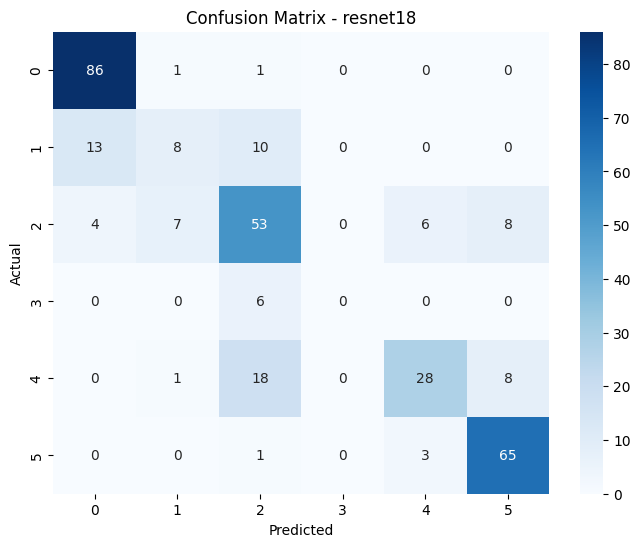


📊 Evaluasi Model: resnet34

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.9438    0.9545    0.9492        88
           1     0.5600    0.4516    0.5000        31
           2     0.6105    0.7436    0.6705        78
           3     0.0000    0.0000    0.0000         6
           4     0.8140    0.6364    0.7143        55
           5     0.8400    0.9130    0.8750        69

    accuracy                         0.7768       327
   macro avg     0.6281    0.6165    0.6182       327
weighted avg     0.7669    0.7768    0.7675       327



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


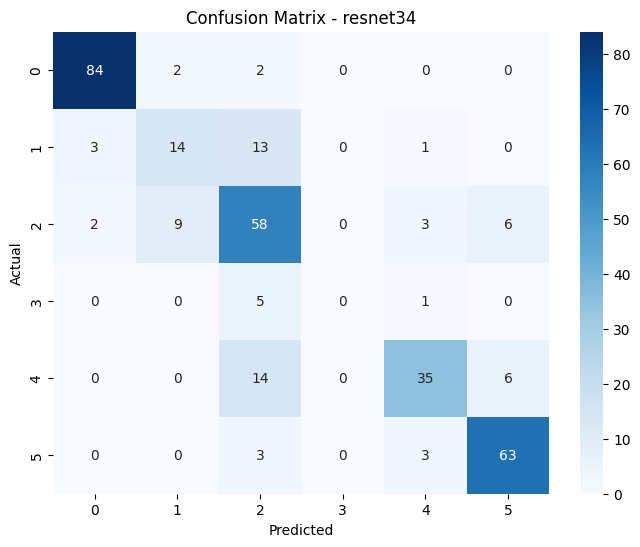


📊 Evaluasi Model: resnet50

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.8485    0.9545    0.8984        88
           1     0.3636    0.2581    0.3019        31
           2     0.5765    0.6282    0.6012        78
           3     0.0000    0.0000    0.0000         6
           4     0.6667    0.5455    0.6000        55
           5     0.8553    0.9420    0.8966        69

    accuracy                         0.7217       327
   macro avg     0.5518    0.5547    0.5497       327
weighted avg     0.6929    0.7217    0.7039       327



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


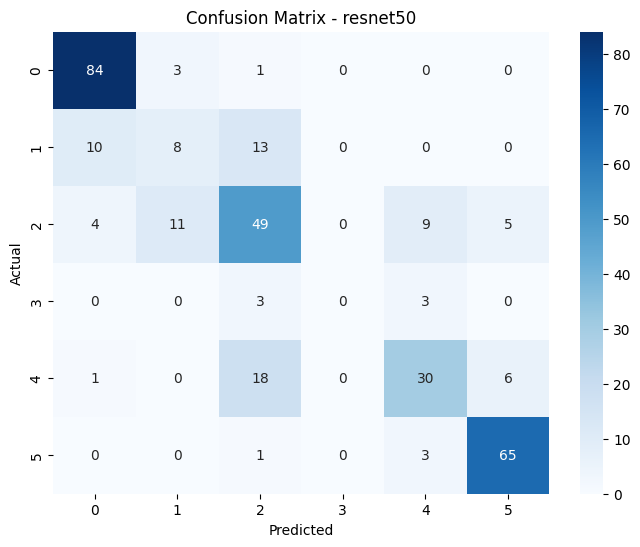


📊 Evaluasi Model: resnet101

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.8557    0.9432    0.8973        88
           1     0.4000    0.2581    0.3137        31
           2     0.5595    0.6026    0.5802        78
           3     0.0000    0.0000    0.0000         6
           4     0.6667    0.6182    0.6415        55
           5     0.8400    0.9130    0.8750        69

    accuracy                         0.7187       327
   macro avg     0.5536    0.5558    0.5513       327
weighted avg     0.6910    0.7187    0.7022       327



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


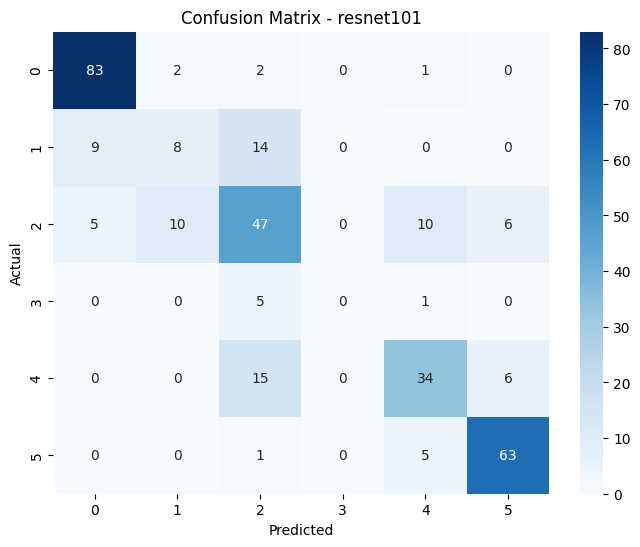


📊 Evaluasi Model: resnet152

📈 Classification Report:
              precision    recall  f1-score   support

           0     0.8660    0.9545    0.9081        88
           1     0.5714    0.5161    0.5424        31
           2     0.5978    0.7051    0.6471        78
           3     0.0000    0.0000    0.0000         6
           4     0.7838    0.5273    0.6304        55
           5     0.8493    0.8986    0.8732        69

    accuracy                         0.7523       327
   macro avg     0.6114    0.6003    0.6002       327
weighted avg     0.7409    0.7523    0.7404       327



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


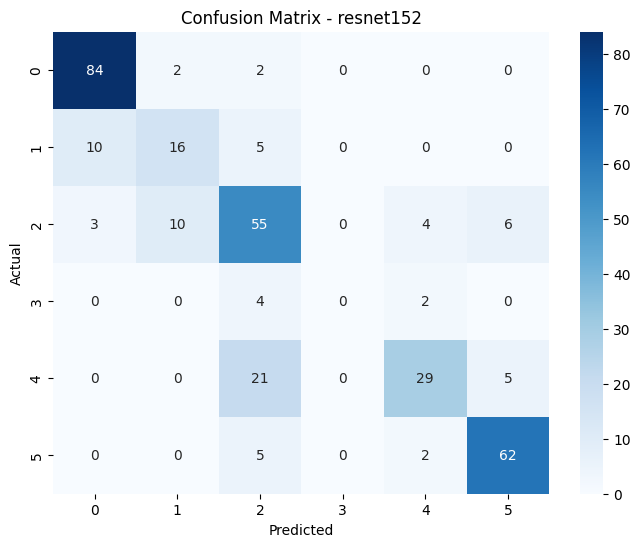

In [ ]:
# Pastikan ini sama dengan struktur saat melatih
resnet_archs = {
    "resnet18": (models.resnet18, 512),
    "resnet34": (models.resnet34, 512),
    "resnet50": (models.resnet50, 2048),
    "resnet101": (models.resnet101, 2048),
    "resnet152": (models.resnet152, 2048),
}

# Dapatkan label kelas dari test set
class_labels = test_dataset.classes
print(f"🔍 Label Kelas Test Set: {class_labels}")

# Evaluasi semua model
for model_name, (arch, feat_dim) in resnet_archs.items():
    evaluate_model_on_test(model_name, arch, feat_dim, test_loader, num_classes, class_labels)


In [ ]:
import os

save_dir = "/content/drive/MyDrive/Model_ResNet_Comvis"
os.makedirs(save_dir, exist_ok=True)

# Contoh: menyimpan ResNet50 setelah frozen dan fine-tune
torch.save(models_dict["resnet18"].state_dict(), f"{save_dir}/best_model_resnet50_frozen.pth")
torch.save(models_dict["resnet18"].state_dict(), f"{save_dir}/best_model_resnet50_fine_tune.pth")
torch.save(models_dict["resnet34"].state_dict(), f"{save_dir}/best_model_resnet50_frozen.pth")
torch.save(models_dict["resnet34"].state_dict(), f"{save_dir}/best_model_resnet50_fine_tune.pth")
torch.save(models_dict["resnet50"].state_dict(), f"{save_dir}/best_model_resnet50_frozen.pth")
torch.save(models_dict["resnet50"].state_dict(), f"{save_dir}/best_model_resnet50_fine_tune.pth")
torch.save(models_dict["resnet101"].state_dict(), f"{save_dir}/best_model_resnet50_frozen.pth")
torch.save(models_dict["resnet101"].state_dict(), f"{save_dir}/best_model_resnet50_fine_tune.pth")
torch.save(models_dict["resnet152"].state_dict(), f"{save_dir}/best_model_resnet50_frozen.pth")
torch.save(models_dict["resnet152"].state_dict(), f"{save_dir}/best_model_resnet50_fine_tune.pth")


# Simpan semua model (frozen)
for name, model in models_dict.items():
    frozen_path = os.path.join(save_dir, f"best_model_{name}_frozen.pth")
    torch.save(model.state_dict(), frozen_path)
    print(f"✅ Disimpan: {frozen_path}")

# Setelah fine-tuning, ulang simpan sebagai fine_tune
for name, model in models_dict.items():
    fine_path = os.path.join(save_dir, f"best_model_{name}_fine_tune.pth")
    torch.save(model.state_dict(), fine_path)
    print(f"✅ Disimpan: {fine_path}")


✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet18_frozen.pth
✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet34_frozen.pth
✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet50_frozen.pth
✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet101_frozen.pth
✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet152_frozen.pth
✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet18_fine_tune.pth
✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet34_fine_tune.pth
✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet50_fine_tune.pth
✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet101_fine_tune.pth
✅ Disimpan: /content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet152_fine_tune.pth


### Memuat Model Trained dari Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
image_size = 224
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dir = '/content/drive/MyDrive/Dataset ComVis/dataset/test'
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = test_dataset.classes
print(f"🔍 Label kelas: {class_names}")


🔍 Label kelas: ['0', '1', '2', '3', '4', '5']


In [ ]:
def load_saved_model(model_name, phase, num_classes=6):
    """
    model_name: 'resnet18', 'resnet34', etc.
    phase: 'frozen' or 'fine_tune'
    """
    model_map = {
        "resnet18": (models.resnet18, 512),
        "resnet34": (models.resnet34, 512),
        "resnet50": (models.resnet50, 2048),
        "resnet101": (models.resnet101, 2048),
        "resnet152": (models.resnet152, 2048)
    }

    if model_name not in model_map:
        raise ValueError("Model tidak dikenal.")

    arch_fn, feat_dim = model_map[model_name]
    model = arch_fn(weights=None)
    model.fc = nn.Sequential(
        nn.Linear(feat_dim, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )
    model = model.to(device)

    # Path file bobot dari Google Drive (ganti jika perlu)
    path = f"/content/drive/MyDrive/Model_ResNet_Comvis/best_model_{model_name}_{phase}.pth"

    if not os.path.exists(path):
        print(f"❌ File model tidak ditemukan: {path}")
        return None

    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"✅ Model '{model_name}' ({phase}) berhasil dimuat.")
    return model


In [ ]:
def evaluate_model(model, data_loader):
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

### GradCam

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2

# Grad-CAM utility class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)
        loss = output[0, class_idx]
        self.model.zero_grad()
        loss.backward()
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        return heatmap.numpy(), torch.softmax(output, dim=1)[0, class_idx].item()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 224
num_classes = 6

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = [str(i) for i in range(num_classes)]

# Path test dataset
test_dirs = {
    str(i): f"/content/drive/MyDrive/Dataset ComVis/dataset/test/{i}" for i in range(num_classes)
}

# Path model .pth
model_paths = {
    "resnet18_frozen": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet18_frozen.pth",
    "resnet18_fine_tune": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet18_fine_tune.pth",
    "resnet34_frozen": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet34_frozen.pth",
    "resnet34_fine_tune": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet34_fine_tune.pth",
    "resnet50_frozen": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet50_frozen.pth",
    "resnet50_fine_tune": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet50_fine_tune.pth",
    "resnet101_frozen": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet101_frozen.pth",
    "resnet101_fine_tune": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet101_fine_tune.pth",
    "resnet152_frozen": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet152_frozen.pth",
    "resnet152_fine_tune": "/content/drive/MyDrive/Model_ResNet_Comvis/best_model_resnet152_fine_tune.pth",
}


In [ ]:
def get_resnet_model(name, path_pth):
    if name.startswith("resnet18"):
        model = models.resnet18(weights=None)
        feat_dim = 512
    elif name.startswith("resnet34"):
        model = models.resnet34(weights=None)
        feat_dim = 512
    elif name.startswith("resnet50"):
        model = models.resnet50(weights=None)
        feat_dim = 2048
    elif name.startswith("resnet101"):
        model = models.resnet101(weights=None)
        feat_dim = 2048
    elif name.startswith("resnet152"):
        model = models.resnet152(weights=None)
        feat_dim = 2048
    else:
        raise ValueError("Unknown model name")

    # Ganti classifier
    model.fc = nn.Sequential(
        nn.Linear(feat_dim, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )

    model.load_state_dict(torch.load(path_pth, map_location=device))
    model = model.to(device).eval()

    return model

# Muat semua model dan siapkan Grad-CAM
models_gc = {}
cams_gc = {}

for name, path in model_paths.items():
    print(f"📦 Loading: {name}")
    model = get_resnet_model(name, path)
    gradcam = GradCAM(model, target_layer=model.layer4[-1])
    models_gc[name] = model
    cams_gc[name] = gradcam


📦 Loading: resnet18_frozen
📦 Loading: resnet18_fine_tune
📦 Loading: resnet34_frozen
📦 Loading: resnet34_fine_tune
📦 Loading: resnet50_frozen
📦 Loading: resnet50_fine_tune
📦 Loading: resnet101_frozen
📦 Loading: resnet101_fine_tune
📦 Loading: resnet152_frozen
📦 Loading: resnet152_fine_tune



🔥 Grad-CAM for model: resnet18_frozen


/tmp/ipython-input-39-2289161236.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


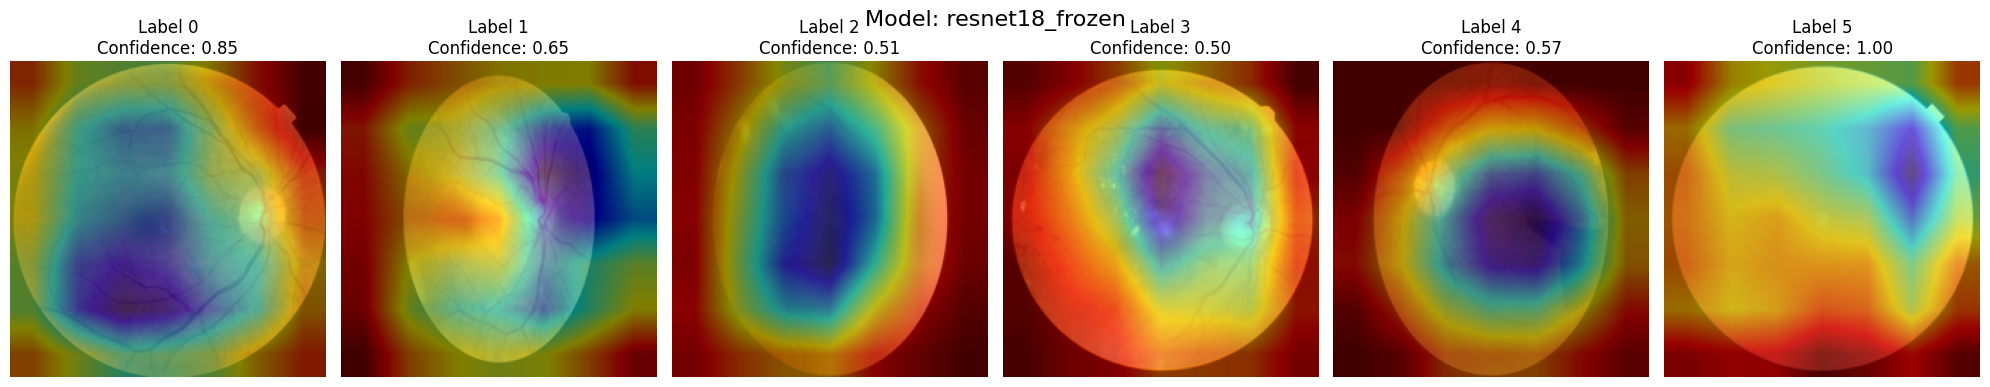


🔥 Grad-CAM for model: resnet18_fine_tune


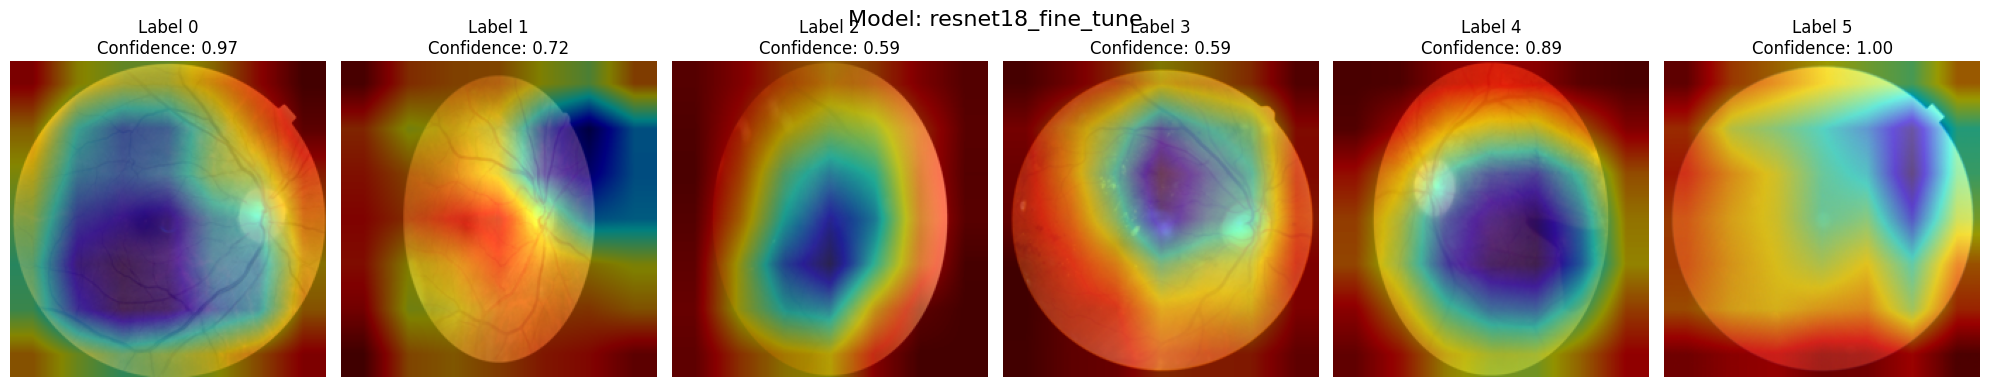


🔥 Grad-CAM for model: resnet34_frozen


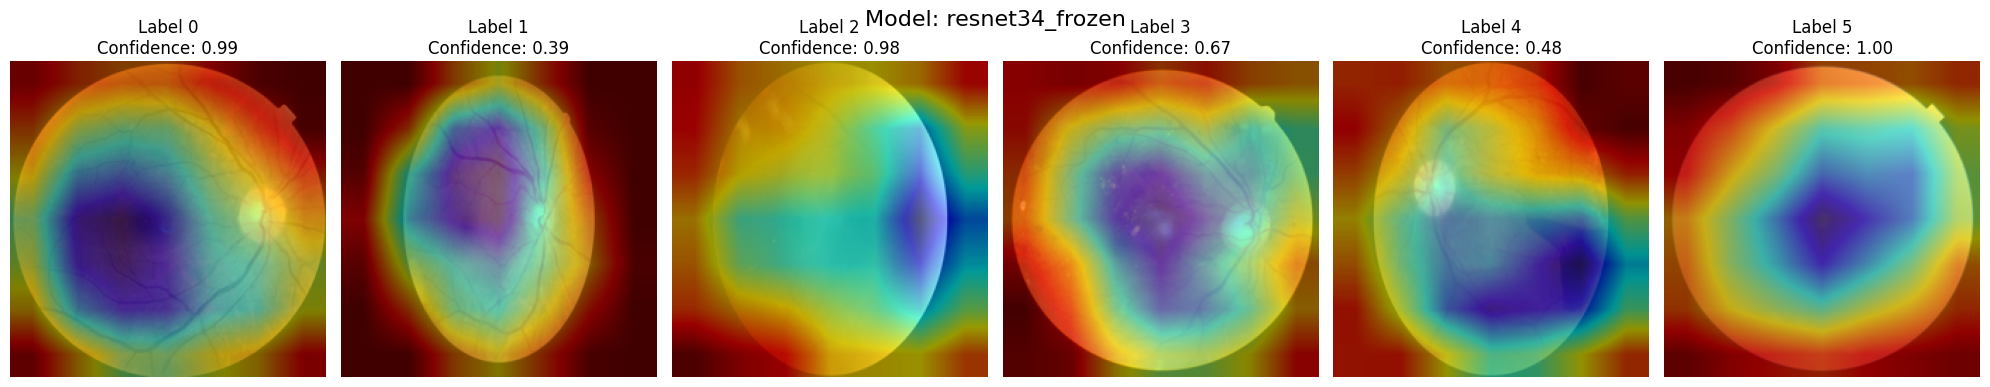


🔥 Grad-CAM for model: resnet34_fine_tune


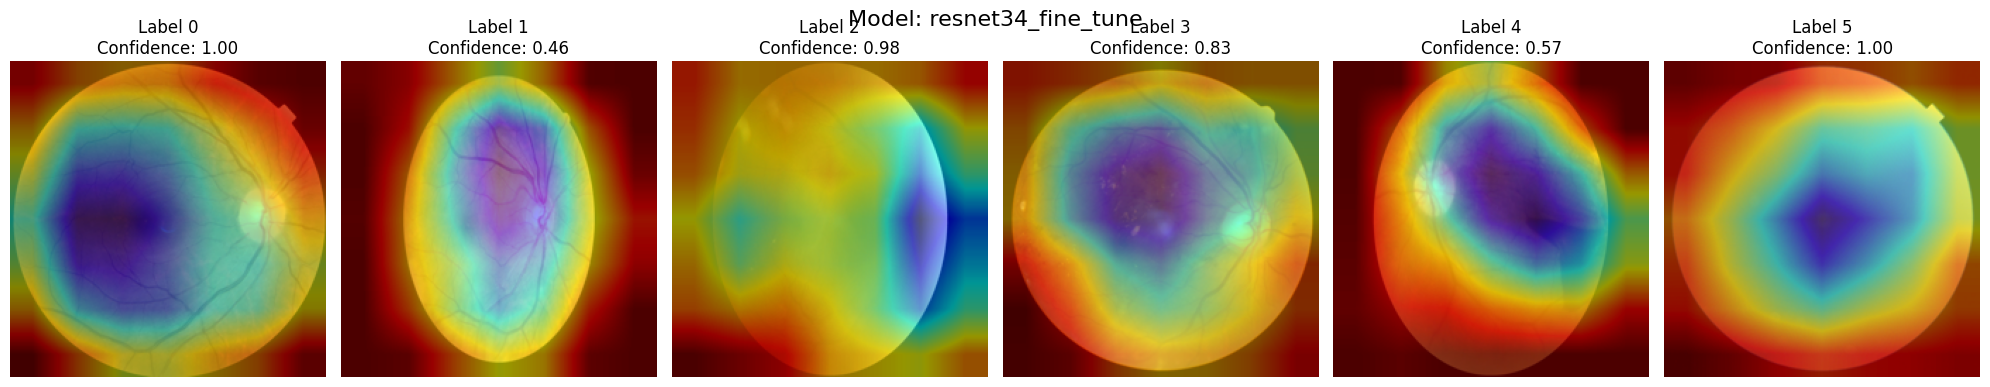


🔥 Grad-CAM for model: resnet50_frozen


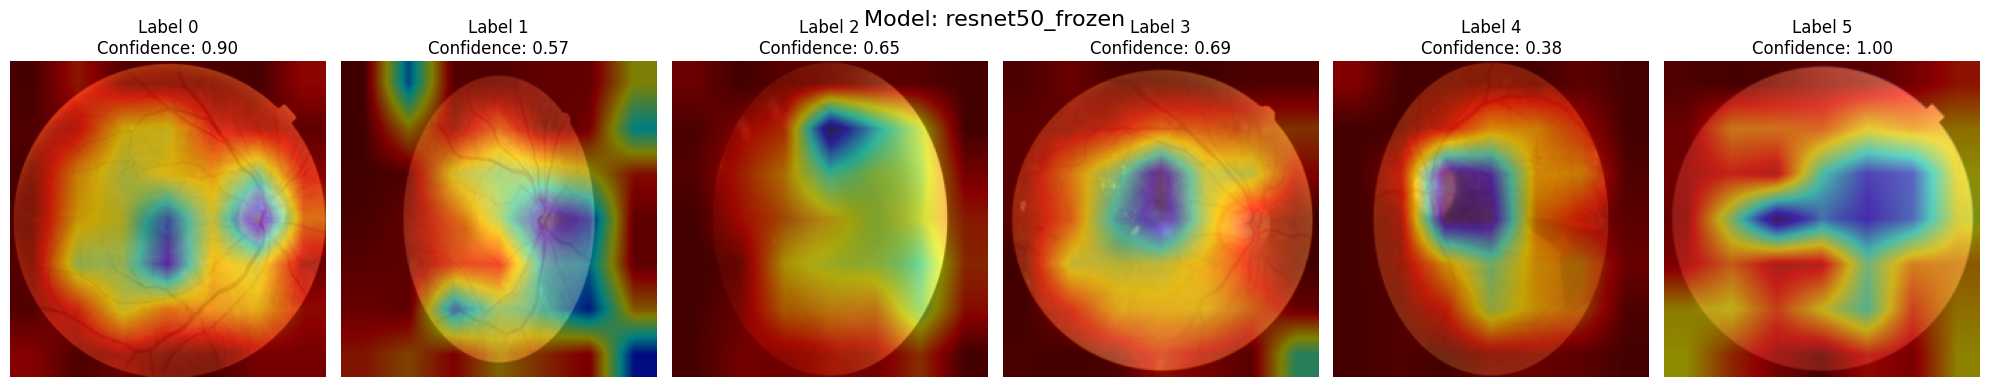


🔥 Grad-CAM for model: resnet50_fine_tune


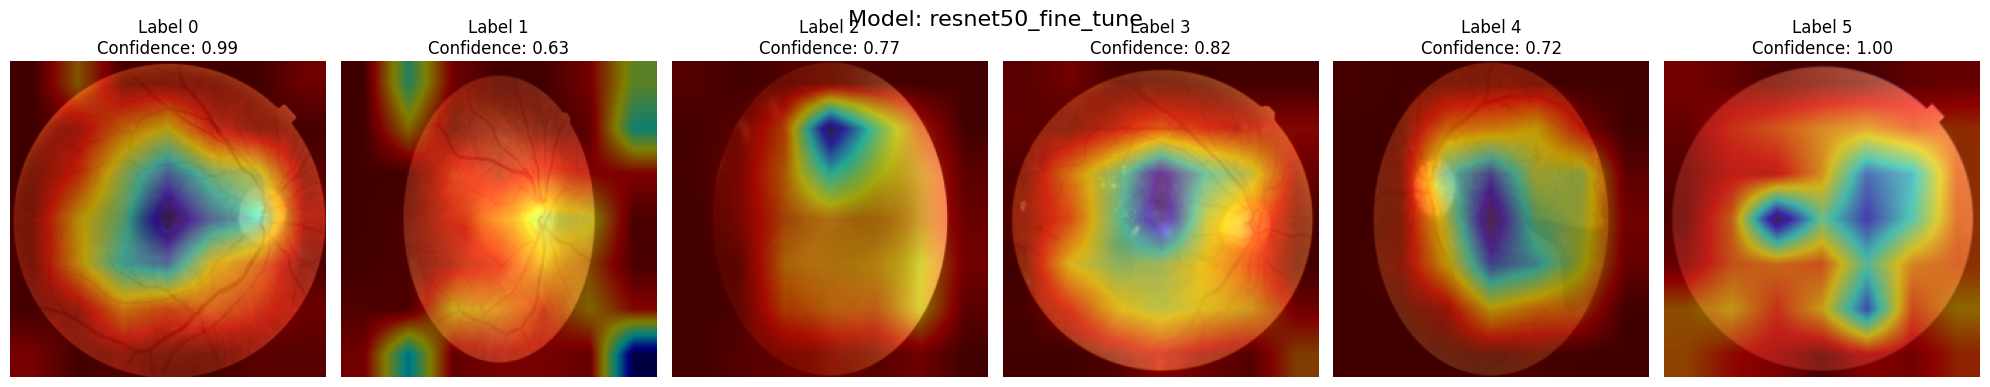


🔥 Grad-CAM for model: resnet101_frozen


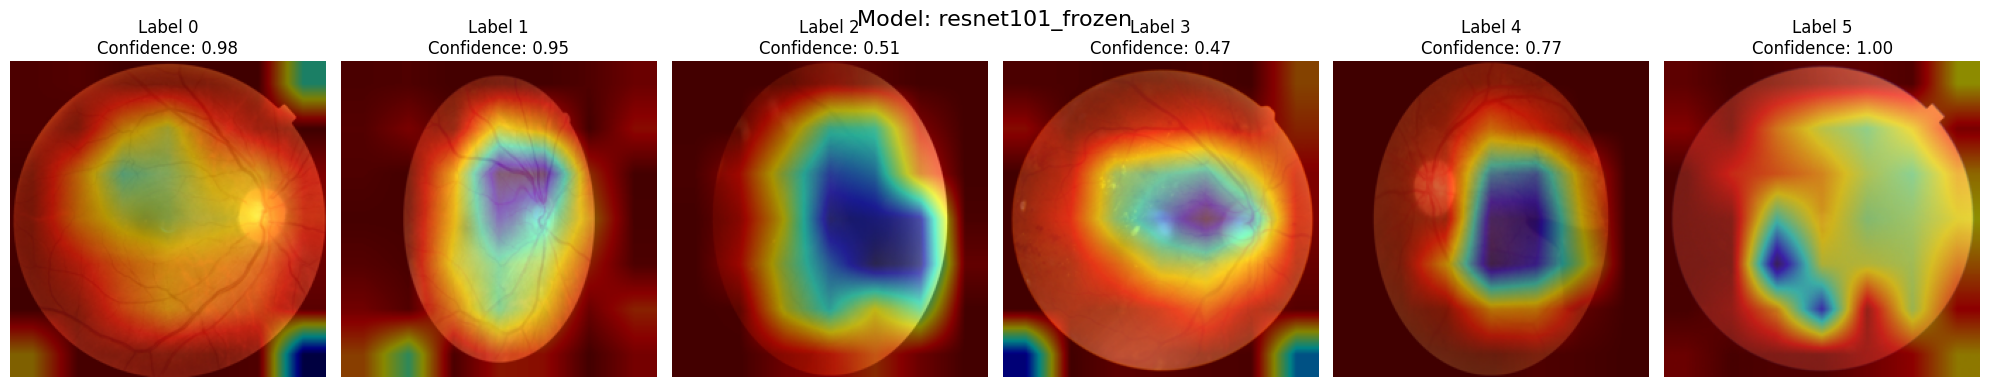


🔥 Grad-CAM for model: resnet101_fine_tune


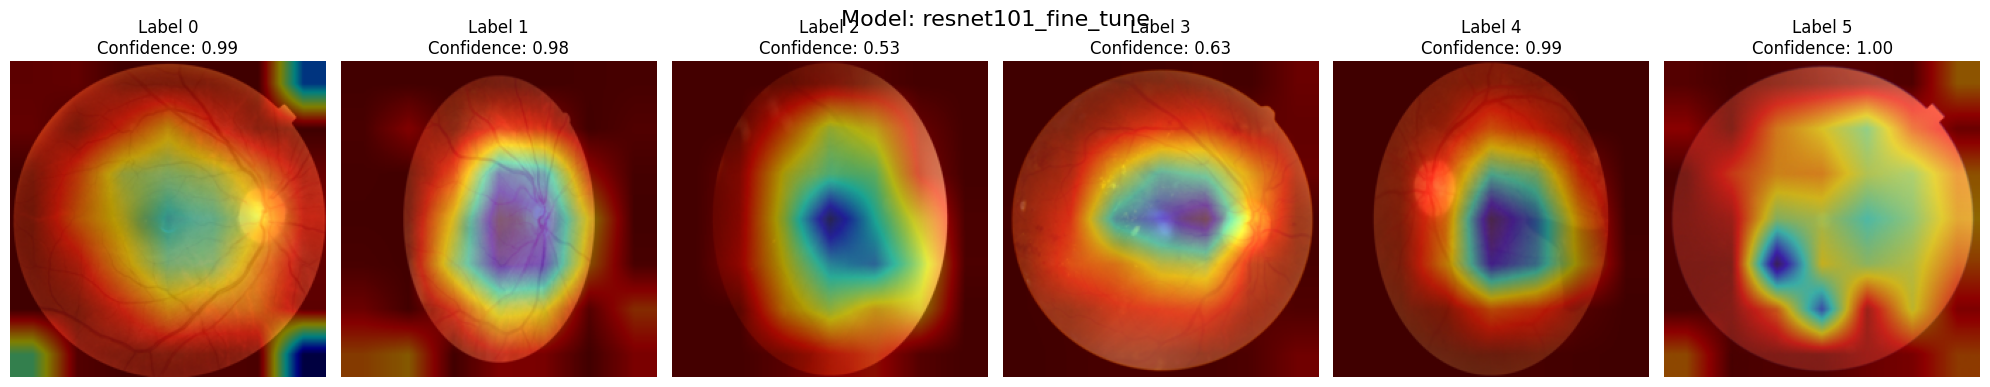


🔥 Grad-CAM for model: resnet152_frozen


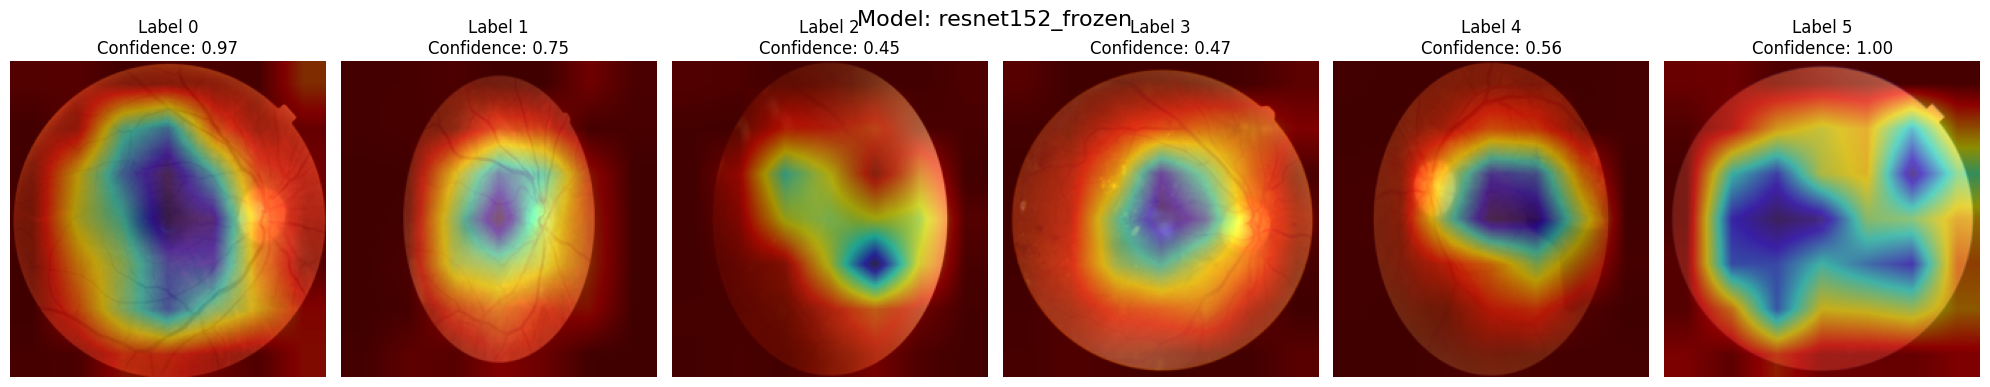


🔥 Grad-CAM for model: resnet152_fine_tune


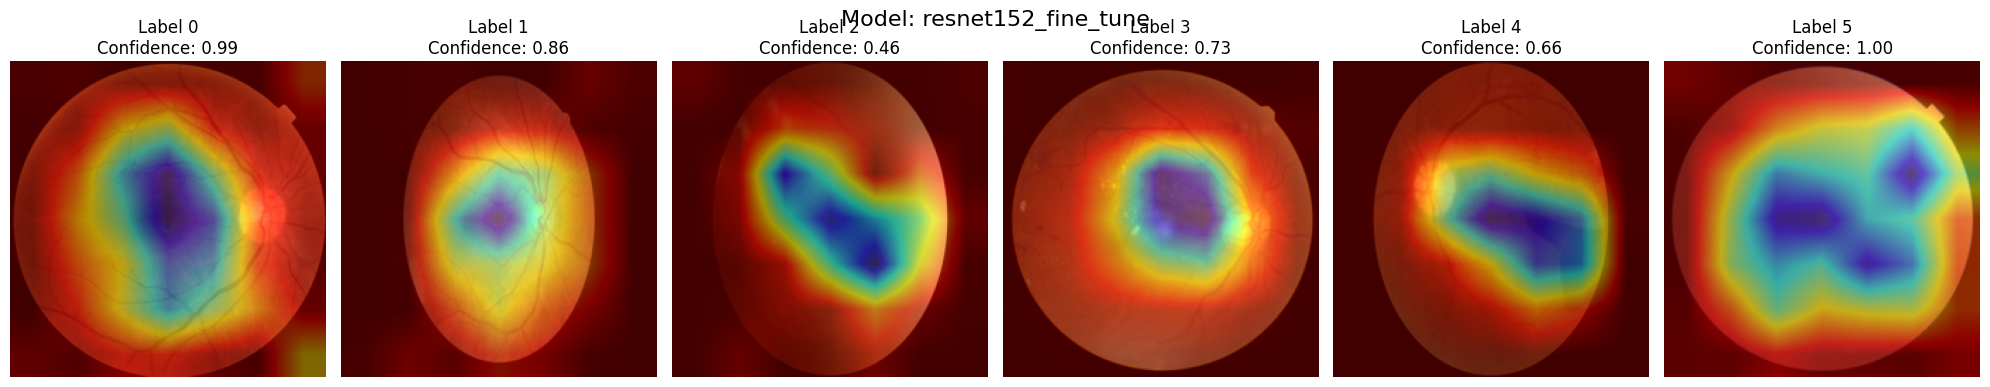

In [ ]:
import matplotlib.pyplot as plt

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    return img, input_tensor

def apply_colormap_on_image(org_img, activation, colormap_name='jet'):
    # Resize activation map ke ukuran gambar (224x224)
    activation = cv2.resize(activation, (image_size, image_size))

    # Normalisasi ke 0–1
    activation = activation - activation.min()
    activation = activation / (activation.max() + 1e-8)

    # Apply colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * activation), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Resize original image dan ubah ke float
    org_img = np.array(org_img.resize((image_size, image_size))) / 255

    # Gabungkan heatmap dan gambar
    cam = heatmap + org_img
    cam = cam / np.max(cam)

    return np.uint8(255 * cam)


# Ambil satu gambar per kelas
sample_images = {}
for label, folder in test_dirs.items():
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            sample_images[label] = os.path.join(folder, fname)
            break

# Proses semua model untuk semua gambar
for model_name in models_gc:
    gradcam = cams_gc[model_name]
    print(f"\n🔥 Grad-CAM for model: {model_name}")

    fig, axes = plt.subplots(1, 6, figsize=(20, 4))
    fig.suptitle(f"Model: {model_name}", fontsize=16)

    for idx, (label, img_path) in enumerate(sample_images.items()):
        raw_img, input_tensor = load_image(img_path)
        activation_map, confidence = gradcam.generate(input_tensor)

        cam_img = apply_colormap_on_image(raw_img, activation_map)

        axes[idx].imshow(cam_img)
        axes[idx].set_title(f"Label {label}\nConfidence: {confidence:.2f}")
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
from PIL import ImageDraw, ImageFont  # ← Tambahkan ini

# 📁 Simpan hasil Grad-CAM setiap model ke Google Drive
save_base_dir = '/content/drive/MyDrive/Grad-CAM_ComVis_Pict'
os.makedirs(save_base_dir, exist_ok=True)

for model_name, model in models_gc.items():  # ← Ganti models_dict → models_gc
    print(f"💾 Menyimpan Grad-CAM untuk model: {model_name}")

    # Buat folder untuk model ini
    model_folder = os.path.join(save_base_dir, model_name)
    os.makedirs(model_folder, exist_ok=True)

    gradcam = cams_gc[model_name]  # ← Pakai gradcam yang sudah disiapkan

    for label_str, image_path in sample_images.items():  # ← Ganti image_paths → sample_images
        raw_img = Image.open(image_path).convert("RGB")
        input_tensor = transform(raw_img).unsqueeze(0).to(device)  # ← Ganti transform_test → transform

        activation_map, confidence = gradcam.generate(input_tensor)
        cam_img = apply_colormap_on_image(raw_img, activation_map)

        # Tambahkan teks confidence ke gambar
        pil_img = Image.fromarray(cam_img)
        draw = ImageDraw.Draw(pil_img)
        font = ImageFont.load_default()
        pred_class = torch.argmax(model(input_tensor)).item()
        label_text = f"Pred: {pred_class} | Conf: {confidence:.2f}"
        draw.text((5, 5), label_text, fill=(255, 255, 255), font=font)

        # Simpan gambar
        save_path = os.path.join(model_folder, f"label_{label_str}.png")
        pil_img.save(save_path)

print("✅ Semua hasil Grad-CAM telah disimpan di Google Drive.")


💾 Menyimpan Grad-CAM untuk model: resnet18_frozen


/tmp/ipython-input-39-2289161236.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


💾 Menyimpan Grad-CAM untuk model: resnet18_fine_tune
💾 Menyimpan Grad-CAM untuk model: resnet34_frozen
💾 Menyimpan Grad-CAM untuk model: resnet34_fine_tune
💾 Menyimpan Grad-CAM untuk model: resnet50_frozen
💾 Menyimpan Grad-CAM untuk model: resnet50_fine_tune
💾 Menyimpan Grad-CAM untuk model: resnet101_frozen
💾 Menyimpan Grad-CAM untuk model: resnet101_fine_tune
💾 Menyimpan Grad-CAM untuk model: resnet152_frozen
💾 Menyimpan Grad-CAM untuk model: resnet152_fine_tune
✅ Semua hasil Grad-CAM telah disimpan di Google Drive.
